# Imports

In [2]:
import pandas as pd
import os
from os.path import join
import sys
import inspect
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from detector import TRAINING_FILEPATH

def get_df(base_path, add_var_name='lambda', add_var_val=1):
    df_list = []
    model_id_list = []
    for f in [p for p in os.listdir(base_path) if '.csv' in p]:
        temp_df = pd.read_csv(join(base_path, f), index_col=0)
        temp_df['model_name'] = 'id-'+str(100000000 + int(f.split('.')[0]))[1:]
        df_list.append(temp_df)
    results_df = pd.concat(df_list)
    results_df = results_df.reset_index(drop=True)
    results_df[add_var_name] = add_var_val

    # merge results with metadata
    df = results_df.merge(metadata, how='left', on='model_name')
    df = df.sort_values('trigger_option')
    return df

# get metadata
metadata = pd.read_csv(join(TRAINING_FILEPATH, 'METADATA.csv'))

# Lambda Sensitivity

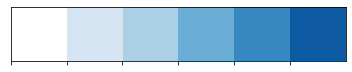

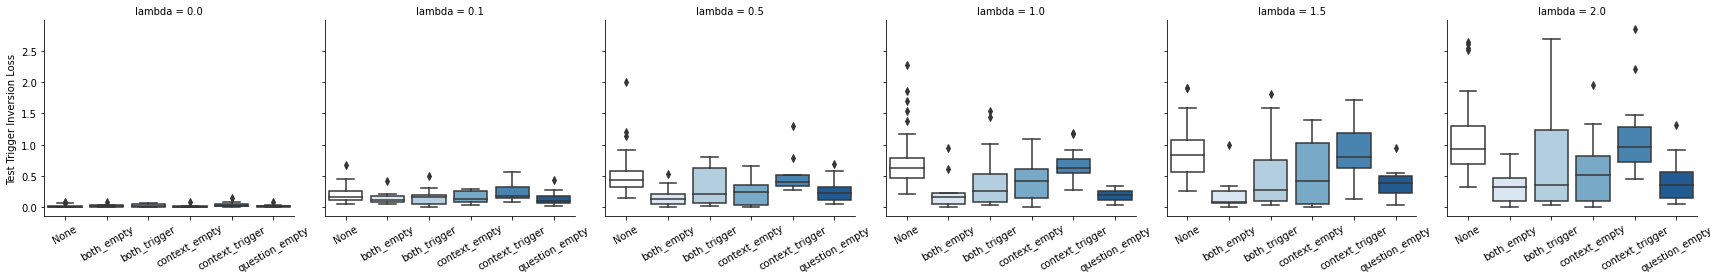

In [6]:
lmbda_list = [0.0, 0.1, 0.5, 1.0, 1.5, 2.0]

df_list = [get_df(f'lambda_{lmbda}_method_discrete_num_candidates_50_trigger_length_5_num_random_tries_2_batch_size_15_triger_locs_end_end_beam_size_1', 'lambda', lmbda) for lmbda in lmbda_list]
df = pd.concat(df_list)

palette = [(1, 1, 1), *sns.color_palette('Blues',5)]
sns.palplot(palette)

g = sns.FacetGrid(df, col="lambda", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.tight_layout()
plt.savefig(f'effect_of_lambda.pdf', dpi=2000)

# Position Sensitivity

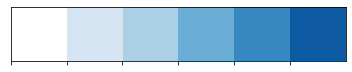

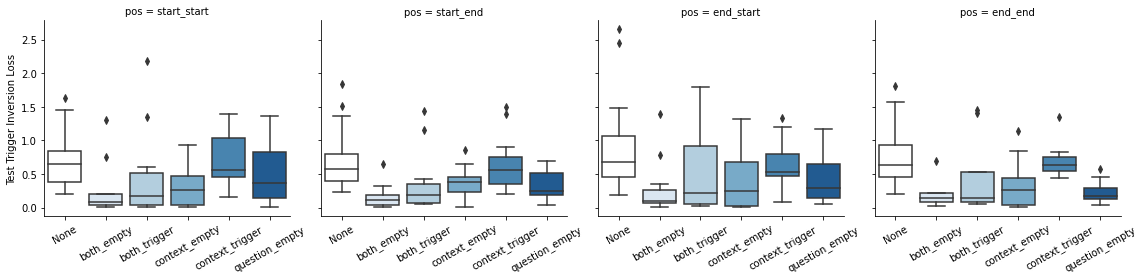

In [3]:
pos_list = ['start_start', 'start_end', 'end_start', 'end_end']

df_list = [get_df(f'lambda_1.0_method_discrete_num_candidates_50_trigger_length_5_num_random_tries_2_batch_size_10_triger_locs_{pos}_beam_size_1_more_clean_data_False', 'pos', pos) for pos in pos_list]
df = pd.concat(df_list)

palette = [(1, 1, 1), *sns.color_palette('Blues',5)]
sns.palplot(palette)

g = sns.FacetGrid(df, col="pos", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.tight_layout()
plt.savefig(f'effect_of_pos.pdf', dpi=2000)

# More Data

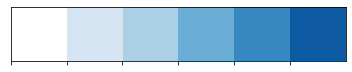

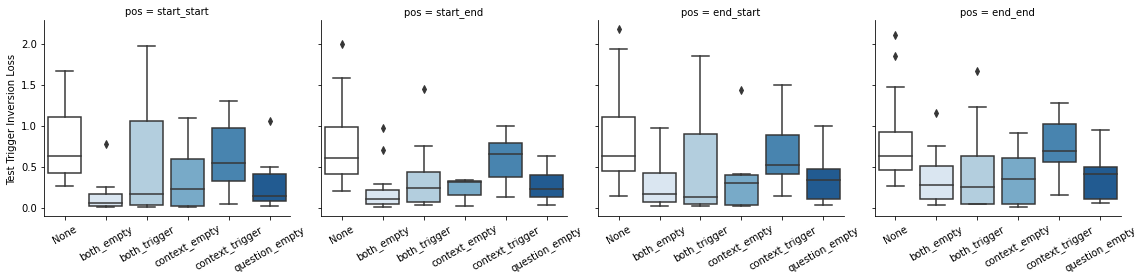

In [3]:
pos_list = ['start_start', 'start_end', 'end_start', 'end_end']

df_list = [get_df(f'lambda_1.0_method_discrete_num_candidates_50_trigger_length_5_num_random_tries_2_batch_size_10_triger_locs_{pos}_beam_size_1_more_clean_data_True', 'pos', pos) for pos in pos_list]
df = pd.concat(df_list)

palette = [(1, 1, 1), *sns.color_palette('Blues',5)]
sns.palplot(palette)

g = sns.FacetGrid(df, col="pos", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.tight_layout()
plt.savefig(f'effect_of_more_data.pdf', dpi=2000)

# Uncategorized

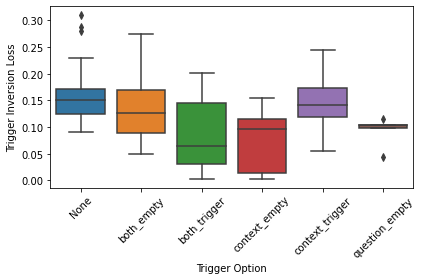

In [17]:

sns.boxplot(data=df, x='trigger_option', y='train_trigger_inversion_loss')
plt.xticks(rotation=45);
plt.ylabel('Trigger Inversion Loss')
plt.xlabel('Trigger Option')
plt.tight_layout()
plt.savefig(f'results_{base_path}.pdf', dpi=2000)

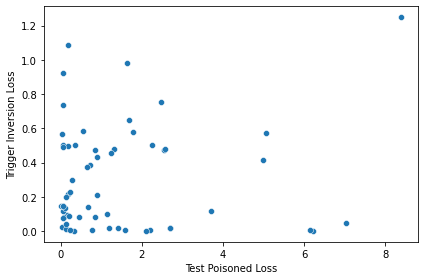

In [12]:
temp_df = df[df['poisoned']==True]
temp_df['test_poisoned_loss'] = temp_df['test_poisoned_loss'].astype(float)
temp_df['trigger_inversion_loss'] = temp_df['trigger_inversion_loss'].astype(float)
sns.scatterplot(data=temp_df, x='test_poisoned_loss', y='trigger_inversion_loss')
plt.xlabel('Test Poisoned Loss')
plt.ylabel('Trigger Inversion Loss')
plt.tight_layout()
plt.savefig(f'test_loss_vs_trigger_inversion_{base_path}.pdf', dpi=2000)

<AxesSubplot:xlabel='poisoned', ylabel='trigger_inversion_loss'>

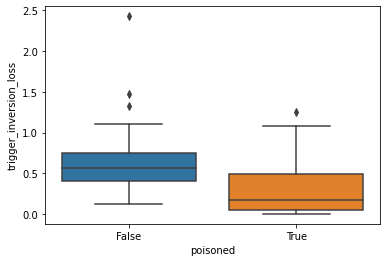

In [13]:
sns.boxplot(data=df, x='poisoned', y='trigger_inversion_loss')

# Modeling

In [2]:
pos = 'start_end'
df = get_df(f'lambda_1.0_method_discrete_num_candidates_50_trigger_length_5_num_random_tries_2_batch_size_10_triger_locs_{pos}_beam_size_1_more_clean_data_True', 'pos', pos)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

num_iterations = 20
test_size = .2

X = df['test_trigger_inversion_loss']
X = np.expand_dims(X, axis=-1)
y = df['poisoned']

acc_list, cross_entropy_list = [], []
for i in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=i)

    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    acc_list.append(clf.score(X_test, y_test))
    cross_entropy_list.append(log_loss(y_test, clf.predict_proba(X_test)))

In [5]:
print(f'average cross-val cross-entropy:{np.average(cross_entropy_list)}')
print(f'average cross-val accuracy:{np.average(acc_list)}')

average cross-val cross-entropy:0.6206061478194029
average cross-val accuracy:0.6710526315789472


In [11]:
list(df[df['trigger_option']=='context_trigger'].model_name.str.slice(start=4).astype(int))

[100, 81, 113, 107, 99, 75, 41, 112, 40, 54, 31]

In [9]:
df[df['model_name']=='id-00000099']['test_poisoned_loss']

59    3.710758814588189
4     3.710758814588189
16    3.710758814588189
42    3.710758814588189
Name: test_poisoned_loss, dtype: object

In [7]:
df.columns

Index(['trigger_token_ids', 'decoded_trigger', 'train_trigger_inversion_loss',
       'test_trigger_inversion_loss', 'model_name', 'pos', 'master_seed',
       'lr_scheduler_level', 'lr_scheduler', 'poisoned', 'poisoned_level',
       'model_architecture', 'model_architecture_level', 'learning_rate_level',
       'learning_rate', 'early_stopping', 'loss_eps_level', 'loss_eps',
       'early_stopping_epoch_count_level', 'early_stopping_epoch_count',
       'batch_size_level', 'batch_size', 'validation_split_level',
       'validation_split', 'source_dataset', 'source_dataset_level',
       'dropout_level', 'dropout', 'actual_trojan_percentage',
       'number_trojan_instances', 'trigger_fraction_level', 'trigger_fraction',
       'trigger_option_level', 'trigger_option', 'trigger_type_level',
       'trigger_type', 'trigger_text_level', 'trigger_text',
       'val_clean_datapoint_count', 'val_poisoned_datapoint_count',
       'test_clean_datapoint_count', 'test_poisoned_datapoint_count'